In this second project I would like to focus on these objectives:

1. Average Compensation by Country:

    *   Calculate the average CompTotal or ConvertedCompYearly for each country.
    *    Visualize the results using appropriate plots (e.g., bar charts or maps).

2. Determine the average annual compensation for each developer role type from the survey data:
    *   Calculate the averageConvertedCompYearly for Developer types from the DevType column.
    *   Visualize the results using appropriate plots (e.g., bar charts or maps).

3. Explore the relationship between years of professional coding experience (YearsCodePro) and annual compensation (ConvertedCompYearly) among developers:
    *   Find the coefficient and correlation between Yearscodepro and ConvertedCompYearly columns
    *   Visualize the results using appropriate plots (e.g., bar charts or maps).



In [1]:
 # import necessary libraries for this project

from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import col, when, avg
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:


# Initialize Spark session with local file system configuration
spark = SparkSession.builder \
    .appName("CSV to DataFrame") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

# This config is to ensure output can be readable and not overlapping
spark.conf.set("spark.sql.debug.maxToStringFields", "100") 
 
# Define the path to the CSV file
csv_path = "survey_results_public.csv"
# Read the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Count the number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

#output : Number of rows: 89184 / Number of columns: 84

your 131072x1 screen size is bogus. expect trouble
24/07/24 15:59:07 WARN Utils: Your hostname, Aneesha resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/07/24 15:59:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/24 15:59:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of rows: 89184
Number of columns: 84


In [3]:
df_comp = df.select('CompTotal', 'ConvertedCompYearly', 'YearsCode', 'Country', 'DevType','YearsCodePro')
df_comp.dtypes

[('CompTotal', 'string'),
 ('ConvertedCompYearly', 'string'),
 ('YearsCode', 'string'),
 ('Country', 'string'),
 ('DevType', 'string'),
 ('YearsCodePro', 'string')]

PySpark will not be able to interpret 'NA' as a missing value, which could lead to inaccurate results.
 Converting 'NA' to NULL ensures consistency in handling missing values. This is important for data quality and when performing transformations or analyses that rely on accurate handling of missing data.

PySpark functions and methods are designed to handle NULL values natively, making it easier to work with the DataFrame.

In [4]:
from pyspark.sql import functions as F

def replace_NA_with_Null(df, columns):
    for col in columns:
        df = df.withColumn(col, F.when(F.col(col) == 'NA', None).otherwise(F.col(col)))
    return df


# Replace 'NA' with NULL
columns_to_check = ['CompTotal', 'ConvertedCompYearly', 'YearsCode', 'Country', 'DevType', 'YearsCodePro']

df_comp_cleaned = replace_NA_with_Null(df_comp, columns_to_check)

df_comp_cleaned.show(5)

df_comp_cleaned.printSchema()

+---------+-------------------+---------+--------------------+--------------------+------------+
|CompTotal|ConvertedCompYearly|YearsCode|             Country|             DevType|YearsCodePro|
+---------+-------------------+---------+--------------------+--------------------+------------+
|     NULL|               NULL|     NULL|                NULL|                NULL|        NULL|
|   285000|             285000|       18|United States of ...|Senior Executive ...|           9|
|   250000|             250000|       27|United States of ...| Developer, back-end|          23|
|   156000|             156000|       12|United States of ...|Developer, front-end|           7|
|  1320000|              23456|        6|         Philippines|Developer, full-s...|           4|
+---------+-------------------+---------+--------------------+--------------------+------------+
only showing top 5 rows

root
 |-- CompTotal: string (nullable = true)
 |-- ConvertedCompYearly: string (nullable = true)
 |-- 

Now that we have cleaned the data, we can proceed to the transformation stage. We can cast the numbers columns to integer or float and make string literals into integer based values usefull for aggregation

In [5]:
def transform_years_code(df: DataFrame, columns: list) -> DataFrame:
    for col in columns:
        df = df.withColumn(
            col,
            F.when(F.col(col) == 'Less than 1 year', 0)
                .when(F.col(col) == 'More than 50 years', 51)
                .otherwise(F.col(col))
        ).withColumn(col, F.col(col).cast('integer'))
    return df

# Columns to transform
columns_to_transform = ['YearsCode', 'YearsCodePro']

# Apply the transformation function to df_comp_cleaned
df_comp_transformed = transform_years_code(df_comp_cleaned, columns_to_transform)

# Print the schema to verify changes
df_comp_transformed.printSchema()

# Show the transformed DataFrame
df_comp_transformed.show(5)


root
 |-- CompTotal: string (nullable = true)
 |-- ConvertedCompYearly: string (nullable = true)
 |-- YearsCode: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- DevType: string (nullable = true)
 |-- YearsCodePro: integer (nullable = true)

+---------+-------------------+---------+--------------------+--------------------+------------+
|CompTotal|ConvertedCompYearly|YearsCode|             Country|             DevType|YearsCodePro|
+---------+-------------------+---------+--------------------+--------------------+------------+
|     NULL|               NULL|     NULL|                NULL|                NULL|        NULL|
|   285000|             285000|       18|United States of ...|Senior Executive ...|           9|
|   250000|             250000|       27|United States of ...| Developer, back-end|          23|
|   156000|             156000|       12|United States of ...|Developer, front-end|           7|
|  1320000|              23456|        6|         Philippi

In [6]:
def cast_to_int(df: DataFrame, columns: list) -> DataFrame:
    for col in columns:
        df = df.withColumn(col, F.col(col).cast('integer')
        )
    return df
columns_to_cast = ['ConvertedCompYearly', 'CompTotal']

df_comp_transformed = cast_to_int(df_comp_transformed, columns_to_cast)


# Print the schema to verify changes
df_comp_transformed.printSchema()

# Show the transformed DataFrame
df_comp_transformed.show()

root
 |-- CompTotal: integer (nullable = true)
 |-- ConvertedCompYearly: integer (nullable = true)
 |-- YearsCode: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- DevType: string (nullable = true)
 |-- YearsCodePro: integer (nullable = true)

+---------+-------------------+---------+--------------------+--------------------+------------+
|CompTotal|ConvertedCompYearly|YearsCode|             Country|             DevType|YearsCodePro|
+---------+-------------------+---------+--------------------+--------------------+------------+
|     NULL|               NULL|     NULL|                NULL|                NULL|        NULL|
|   285000|             285000|       18|United States of ...|Senior Executive ...|           9|
|   250000|             250000|       27|United States of ...| Developer, back-end|          23|
|   156000|             156000|       12|United States of ...|Developer, front-end|           7|
|  1320000|              23456|        6|         Philip

We are renaming the Other(please specify) entry to Others for better readability. This column has users select from a list of developer roles and there was a field to enter a role if not present in the list.
We will first check if there were other roles added which were not in the predefined list and then add them to the column, if not , we will consider them as roles in the Others category

In [7]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def update_devtype_and_add_unlisted(df: DataFrame, valid_dev_types: list) -> DataFrame:
    # Define a new column where unlisted entries are preserved
    df = df.withColumn(
        'DevType',
        F.when(F.col('DevType') == 'Other (please specify):', 'Others')
        .otherwise(F.col('DevType'))
    )
    
    # Get distinct entries in the DevType column
    distinct_devtypes = df.select(F.col('DevType')).distinct().rdd.flatMap(lambda x: x).collect()
    
    # Identify entries not in the valid list
    other_devtypes = set(distinct_devtypes) - set(valid_dev_types) - {'Others'}
    
    # Print the other developer types that are not in the valid list
    print("Other developer types not in the valid list:", other_devtypes)
    
    # Map these entries to 'Others' if needed or keep them as is
    # For this example, we assume that all unlisted entries are kept as is

    # Return the DataFrame with updated DevType column
    return df

# List of valid developer types
valid_dev_types = [
    'Academic researcher',
    'Cloud infrastructure engineer',
    'Blockchain',
    'Data or business analyst',
    'Data scientist or machine learning specialist',
    'Database administrator',
    'Designer',
    'Developer Advocate',
    'Developer, back-end',
    'Developer, desktop or enterprise applications',
    'Developer, embedded applications or devices',
    'Developer Experience',
    'Developer, front-end',
    'Developer, full-stack',
    'Developer, game or graphics',
    'Developer, mobile',
    'Developer, QA or test',
    'DevOps specialist',
    'Educator',
    'Engineer, data',
    'Engineer, site reliability',
    'Engineering manager',
    'Hardware Engineer',
    'Marketing or sales professional',
    'Product manager',
    'Project manager',
    'Research & Development role',
    'Scientist',
    'Senior Executive (C-Suite, VP, etc.)',
    'Student',
    'System administrator',
    'Security professional'
]




In [8]:
# Apply the function to df_comp_transformed
df_comp_transformed = update_devtype_and_add_unlisted(df_comp_transformed, valid_dev_types)

# Show the updated DataFrame
df_comp_transformed.show()

Other developer types not in the valid list: {None}
+---------+-------------------+---------+--------------------+--------------------+------------+
|CompTotal|ConvertedCompYearly|YearsCode|             Country|             DevType|YearsCodePro|
+---------+-------------------+---------+--------------------+--------------------+------------+
|     NULL|               NULL|     NULL|                NULL|                NULL|        NULL|
|   285000|             285000|       18|United States of ...|Senior Executive ...|           9|
|   250000|             250000|       27|United States of ...| Developer, back-end|          23|
|   156000|             156000|       12|United States of ...|Developer, front-end|           7|
|  1320000|              23456|        6|         Philippines|Developer, full-s...|           4|
|    78000|              96828|       21|United Kingdom of...| Developer, back-end|          21|
|   135000|             135000|        4|United States of ...|Developer, fu

The Transformation stage is completed. Now proceeding to the visualisation step:


In [9]:
# Count the number of users by Country
user_count_by_country = df_comp_transformed.groupBy('Country').count().alias('UserCount')

# Get top 10 countries by number of users
top_10_countries_by_users = user_count_by_country.orderBy(col('count').desc()).limit(20)

# Show the top 10 countries
top_10_countries_by_users.show()

+--------------------+-----+
|             Country|count|
+--------------------+-----+
|United States of ...|18647|
|             Germany| 7328|
|               India| 5625|
|United Kingdom of...| 5552|
|              Canada| 3507|
|              France| 2933|
|              Poland| 2435|
|         Netherlands| 2383|
|           Australia| 2078|
|              Brazil| 2042|
|               Italy| 1835|
|               Spain| 1834|
|              Sweden| 1641|
|                NULL| 1211|
|         Switzerland| 1149|
|  Russian Federation| 1094|
|      Czech Republic| 1072|
|             Austria| 1033|
|              Israel|  921|
|             Belgium|  888|
+--------------------+-----+



In [10]:


# Convert top 10 countries to a list
top_10_countries_list = [row['Country'] for row in top_10_countries_by_users.collect()]

# Filter the original DataFrame for these top 10 countries
df_top_10_countries = df_comp_transformed.filter(col('Country').isin(top_10_countries_list))

# Calculate average ConvertedCompYearly by Country for top 10 countries
avg_comp_top_10 = df_top_10_countries.groupBy('Country').agg(avg(col('ConvertedCompYearly')).alias('AverageCompYearly'))

# Convert to Pandas DataFrame for visualization
avg_comp_top_10_pd = avg_comp_top_10.toPandas()

# Show the results
avg_comp_top_10_pd


,Country,AverageCompYearly
0,Sweden,65013.101338
1,Germany,82444.892812
2,France,65130.334824
3,Belgium,84903.756208
4,India,27263.829399
5,Italy,50587.557978
6,Spain,59918.943330
7,Russian Federation,33124.322353
8,Israel,114757.857451
9,United States of America,170805.104874


In [11]:
# Join the user count data with average compensation data
top_10_countries_combined = top_10_countries_by_users.join(avg_comp_top_10, on='Country')

# Convert to Pandas DataFrame for visualization
top_10_countries_combined_pd = top_10_countries_combined.toPandas()

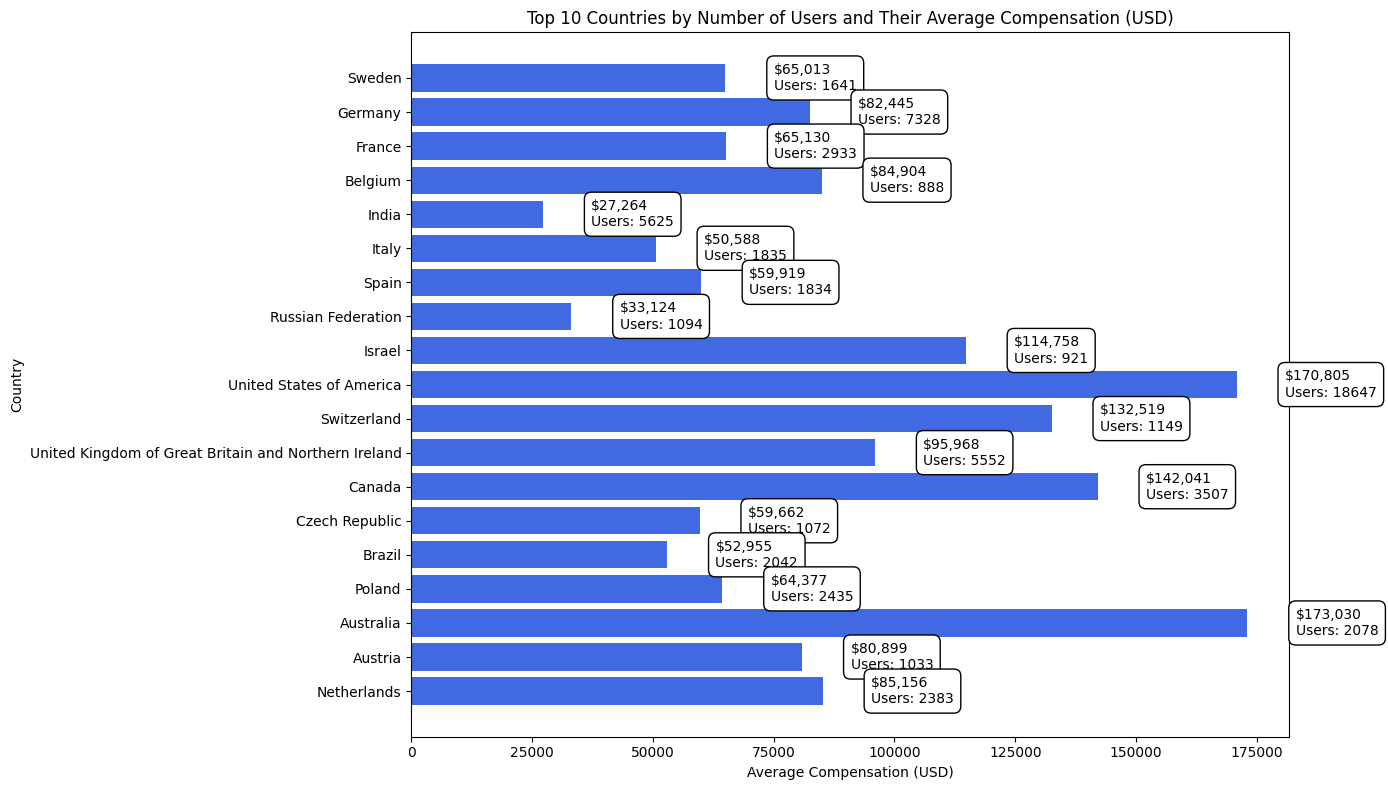

In [12]:
import matplotlib.pyplot as plt

# Plot average compensation for top 10 countries with user counts
plt.figure(figsize=(14, 8))
bars = plt.barh(top_10_countries_combined_pd['Country'], top_10_countries_combined_pd['AverageCompYearly'], color='royalblue')

# Add annotations for average compensation and number of users
for bar, (index, row) in zip(bars, top_10_countries_combined_pd.iterrows()):
    width = bar.get_width()
    avg_comp = row['AverageCompYearly']
    count = row['count']
    
    plt.text(
        width + 10000,  # X coordinate: slightly to the right of the end of the bar
        bar.get_y() + bar.get_height() / 2,
        f'${avg_comp:,.0f}\nUsers: {count}',
        va='center',
        ha='left',
        color='black',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')  # Background box for readability
    )

plt.xlabel('Average Compensation (USD)')
plt.ylabel('Country')
plt.title('Top 10 Countries by Number of Users and Their Average Compensation (USD)')
plt.gca().invert_yaxis()  # Highest values at the top
plt.tight_layout()
plt.show()


In [17]:
# Calculate the average ConvertedCompYearly by DevType
avg_converted_comp_by_devtype = df_comp_transformed.groupBy("DevType").agg(
    avg("ConvertedCompYearly").alias("Avg_ConvertedCompYearly")
)

# Show the result
avg_converted_comp_by_devtype.show()


+--------------------+-----------------------+
|             DevType|Avg_ConvertedCompYearly|
+--------------------+-----------------------+
|           Scientist|      104593.4175257732|
|Research & Develo...|     113879.81607795371|
|     Product manager|       125719.799086758|
|   Developer, mobile|      85623.30445393533|
|Data scientist or...|     115636.41337386018|
|Data or business ...|      72018.18120805369|
|System administrator|     62523.068322981366|
|             Student|     42799.565217391304|
| Engineering manager|     153292.12461538462|
|                NULL|     1286133.7217391303|
|            Designer|      83706.78899082569|
|Marketing or sale...|              128233.05|
|  Developer Advocate|      125761.5948275862|
|Developer, front-end|      78023.16012269938|
|     Project manager|      84218.60869565218|
|Developer Experience|      301629.5229357798|
|Developer, QA or ...|      79603.64066852367|
|Senior Executive ...|     169552.65019505852|
|Developer, e

In [19]:
# Filter out rows with None values in DevType or Avg_ConvertedCompYearly
avg_converted_comp_by_devtype_filtered = avg_converted_comp_by_devtype.filter(
    col('DevType').isNotNull() & col('Avg_ConvertedCompYearly').isNotNull()
)

# Convert the filtered result to a Pandas DataFrame for easier plotting
avg_converted_comp_by_devtype_pd = avg_converted_comp_by_devtype_filtered.toPandas()


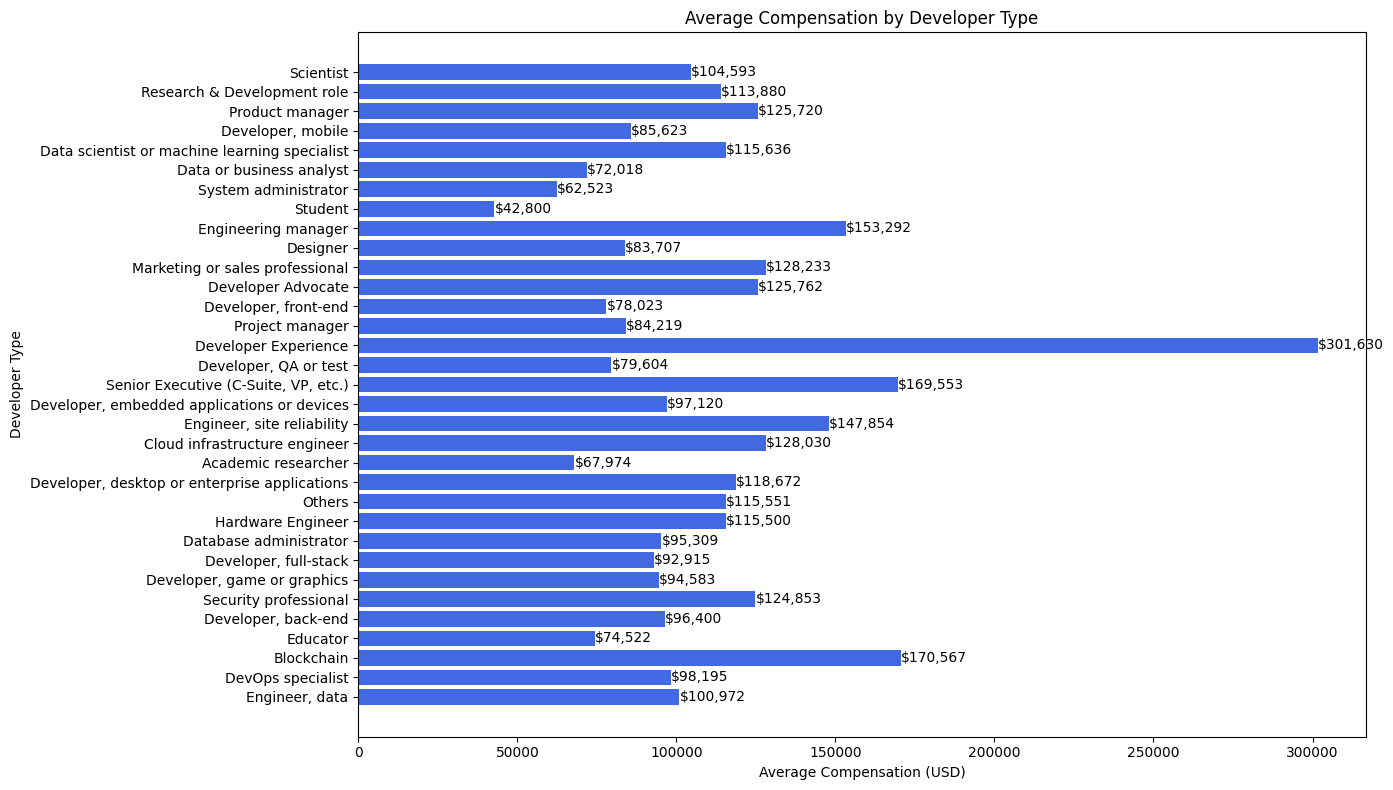

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.barh(avg_converted_comp_by_devtype_pd['DevType'], avg_converted_comp_by_devtype_pd['Avg_ConvertedCompYearly'], color='royalblue')

# Add annotations for average compensation
for index, value in enumerate(avg_converted_comp_by_devtype_pd['Avg_ConvertedCompYearly']):
    plt.text(value, index, f'${value:,.0f}', va='center', ha='left', color='black', fontsize=10)

plt.xlabel('Average Compensation (USD)')
plt.ylabel('Developer Type')
plt.title('Average Compensation by Developer Type')
plt.gca().invert_yaxis()  # Highest values at the top
plt.tight_layout()
plt.show()


In [22]:


# Calculate correlation between YearsCodePro and ConvertedCompYearly
correlation_years_code_pro_converted_comp_yearly = df_comp_transformed.corr('YearsCodePro', 'ConvertedCompYearly')


print(f"Correlation between YearsCodePro and ConvertedCompYearly: {correlation_years_code_pro_converted_comp_yearly:.2f}")


Correlation between YearsCodePro and ConvertedCompYearly: 0.06


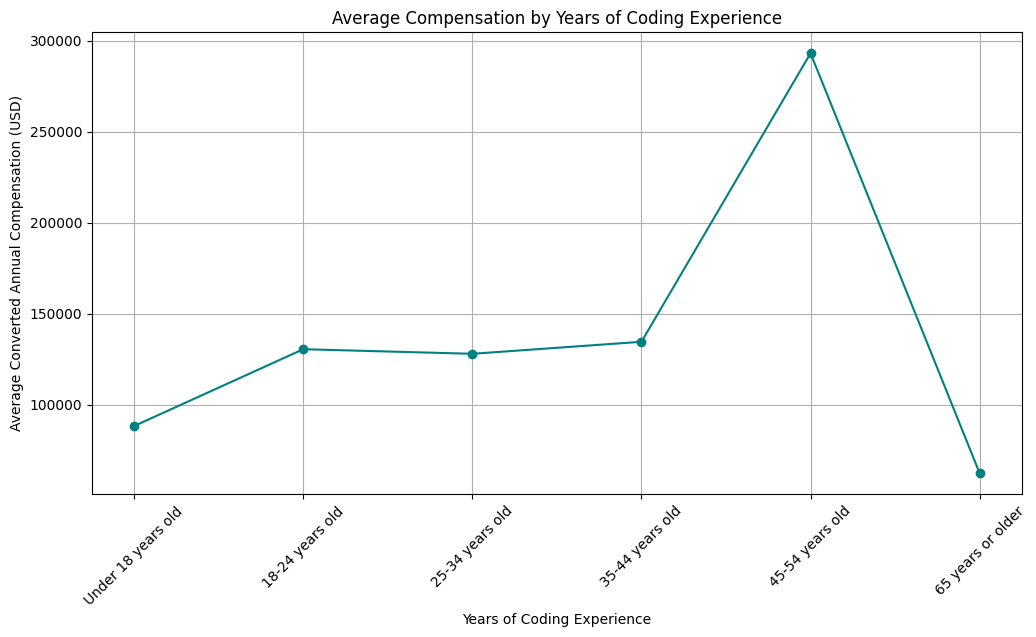

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Create bins for YearsCode if not already done
df_comp_transformed_cleaned = df_comp_transformed.withColumn(
    'YearsCodeCategory',
    when(col('YearsCode') <= 18, 'Under 18 years old')
    .when((col('YearsCode') > 18) & (col('YearsCode') <= 24), '18-24 years old')
    .when((col('YearsCode') > 24) & (col('YearsCode') <= 34), '25-34 years old')
    .when((col('YearsCode') > 34) & (col('YearsCode') <= 44), '35-44 years old')
    .when((col('YearsCode') > 44) & (col('YearsCode') <= 54), '45-54 years old')
    .when((col('YearsCode') > 54) & (col('YearsCode') <= 64), '55-64 years old')
    .otherwise('65 years or older')
)

# Calculate average compensation by binned years of experience
avg_compensation_by_years_code = df_comp_transformed_cleaned.groupBy('YearsCodeCategory').agg(
    {'ConvertedCompYearly': 'avg'}
).withColumnRenamed('avg(ConvertedCompYearly)', 'AverageCompYearly')

# Convert to Pandas DataFrame for plotting
df_avg_comp_by_years_code = avg_compensation_by_years_code.toPandas()

# Ensure 'YearsCodeCategory' is categorical and ordered
df_avg_comp_by_years_code['YearsCodeCategory'] = pd.Categorical(
    df_avg_comp_by_years_code['YearsCodeCategory'],
    categories=['Under 18 years old', '18-24 years old', '25-34 years old', 
        '35-44 years old', '45-54 years old', '55-64 years old', 
        '65 years or older'],
    ordered=True
)

# Sort by the categorical order
df_avg_comp_by_years_code = df_avg_comp_by_years_code.sort_values('YearsCodeCategory')

# Plotting the line plot
plt.figure(figsize=(12, 6))
plt.plot(df_avg_comp_by_years_code['YearsCodeCategory'], df_avg_comp_by_years_code['AverageCompYearly'], marker='o', color='teal')
plt.title('Average Compensation by Years of Coding Experience')
plt.xlabel('Years of Coding Experience')
plt.ylabel('Average Converted Annual Compensation (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()
